<a id='g1'></a>
# Grade 1
## Implement a complete process for forecasting the one-day-ahead Close value of the EUR/USD exchange rate, using a historical dataset with one-minute resolution.

You should do the following steps:
- Download once the [EUR/USD data set](https://people.arcada.fi/~parland/hjd5_8amp_Gt3/EURUSD1m.zip) (52Mb) and convert the index to [DatetimeIndex](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html)
`pd.read_csv("https://people.arcada.fi/~parland/hjd5_8amp_Gt3/EURUSD1m.zip", compression='zip', [other usefull parameters...])`

- Subsample data to one-day time steps, ensuring you also include data from weekends.

- Create a 'Label' column for your forecast by shifting the Close value one step forward. You will be predicting one day ahead.

- Split the data into an 80/20 ratio (train/test). Be cautious: you are splitting a time series.


- [Normalize or standardize](https://scikit-learn.org/stable/modules/preprocessing.html) wisely so you don't allow information leakage to the test subset. Note, that utility class [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) performs scaling **individual samples to have unit norm**, so it is not useful for certain tasks. Write your own function or check [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) or [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

- Please check in which order you perform split and scale. The order in which you perform the split and scaling is crucial, especially for time series data, and each approach has its pros and cons:

1. **Data → X, y → scale → split → X_test, y_test ; X_train, y_train**: 
    - **Pros**: Easier to implement because you're scaling everything all at once.
    - **Cons**: You're scaling the test set based on the statistics of the entire dataset, including the test set itself, which is often considered a form of data leakage. This can potentially give you overly optimistic evaluations of your model's performance.

2. **Data → X, y → split → scale → X_test, y_test ; X_train, y_train**:
    - **Pros**: You're not leaking information from the test set into the training set. The training set is scaled based on its own statistics, and the test set is similarly scaled based on the training set's statistics.
    - **Cons**: A bit more cumbersome to implement, as you have to fit the scaler to the training data and then use it to transform both the training and test data.

**Note**: When you transform the data, you indeed have to transform your forecasts back into their original form to make them interpretable. Saving the parameters used for normalization or standardization is essential for this "de-normalization" process. This is especially important in the second approach, where the test set is scaled based on the statistics of the training set.

- Calculate the technical analysis feature [Larry William’s %R](https://www.investopedia.com/terms/w/williamsr.asp) from the paper [Predicting the Direction of Stock Market Index Movement Using an Optimized Artificial Neural Network Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4873195) (implement in code, insert values in a complementary column). 

**Note that you need to implement your own calculation of each feature and be able to explain the code.**

- Drop other data than the Close and the features for training and inference. You don't want to feed time-column into the model, it's usually not a feature to base your prediction on. 

- Fit a [linear model](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) to the training data

- Forecast one day ahead based on the test data

- Calculate the [R² error](https://en.wikipedia.org/wiki/Coefficient_of_determination) on both the training data set and the test. Please format numbers to four [significant digits](https://en.wikipedia.org/wiki/Significant_figures). As a check you may note that values suppose to be in the range 0.975 … 0.993 for test and 0.995 … 0.998 for train. If you get R² error outside these ranges it **indicates** that you are highly likely to have an error in your program logic.

**NB! You may also get an expected result by performing several cumulative mistakes. Imagine a question:**  

$$ (2+1)\times 3 = ?$$

$$ \text{Erroneous attempt: each step is wrong, the end result is right...} $$
$$ 2+1=4 $$
$$ 4\times 3 = 9 $$
$$ \text{Answer: } 9 $$

**The objective of this assignment is not to achieve a correct result but to achieve the result correctly.**

- Compare the R² errors for test and train and explain the outcome. 

- Extra: Test your model (get R² errors for test and train without LW%R, just Close column). Comment and explain the result. A reasonable explanation will compensate for one error in the following grades.

### **Larry William’s %R**

$ (H_n − C_t)/(H_n − L_n)\times100 $

Where:

- $ H_n $: The highest price reached during the specified period $ n $.
- $ C_t $: The closing price at time $ t $.
- $ L_n $: The lowest price reached during the specified period $ n $.

The idea behind the %R indicator is to measure the level of the close relative to the range of prices (high to low) over a set period of time. 
### Coefficient of determination ($R^2$)

$$R^2 = 1 - \frac {SS_{Resid}}{SS_{Tot}}$$

#### Residual Sum of Squares: $SS_{Resid} = \sum_{i} (y_i - \hat{y_i})^2$

#### Total Sum of Squares: $SS_{Tot} = \sum_{i} (y_i - \bar{y})^2$

#### A baseline model, which always predicts $\bar {y}$, will have $R^2 = 0$

Below is an example code for a Disparity Index feature calculation for 5 days: $ \frac {C_t}  {\text{MA}_5} \times 100 $
([See the explanation](https://www.investopedia.com/terms/d/disparityindex.asp))
# example
def disparity_5(df):
    return 100 * df['Close'] / df['Close'].rolling(window=5).mean()

df['Disparity_5'] = disparity_5(df)



In [587]:
# First upgrade the environment.
# import pip
from subprocess import run
# add & upgrade what you will need
modules =[
    'pandas_market_calendars',
    'plotly',
    'numpy',
    'scikit-learn',
    'pandas',
    'matplotlib'
]
proc = run(f'pip install {" ".join(modules)} --upgrade --no-input',
           shell=True,
           text=True,
           capture_output=True,
           timeout=120) #a couple of minutes
print(proc.stderr)


In [588]:
import pandas as pd
from pathlib import Path
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, StrMethodFormatter
%matplotlib inline

import plotly as ply
import plotly.graph_objects as go

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

from functools import reduce
from operator import mul
from pprint import PrettyPrinter
pprint = PrettyPrinter().pprint

In [589]:
#Import the file from the source

df=pd.read_csv("https://people.arcada.fi/~parland/hjd5_8amp_Gt3/EURUSD1m.zip")

In [590]:
df.tail()

,Date,Timestamp,Open,High,Low,Close,Volume
3735009,20191231,11:55:00,1.12266,1.12267,1.12250,1.12251,196.390000
3735010,20191231,11:56:00,1.12250,1.12261,1.12247,1.12251,167.640000
3735011,20191231,11:57:00,1.12254,1.12273,1.12254,1.12271,164.570002
3735012,20191231,11:58:00,1.12271,1.12283,1.12262,1.12275,244.780001
3735013,20191231,11:59:00,1.12276,1.12281,1.12272,1.12277,219.340002


In [591]:
df["DateTimeIndex"]=pd.to_datetime(df['Date'].astype(str)+' '+df['Timestamp'].astype(str))

In [592]:
df.drop(columns=['Date','Timestamp'],inplace=True)

In [593]:
df.index=df['DateTimeIndex']

In [594]:
df.drop(columns='DateTimeIndex',inplace=True)

In [595]:
df.loc[df.index.weekday==5]=df.shift(-24).dropna()

In [596]:
df=df.dropna()


In [597]:
daily_close_data=pd.DataFrame()

In [598]:
daily_close_data=df.resample('D').mean()

daily_close_data=daily_close_data.dropna()

In [599]:
#Function to standardize the data
def Standardize_here(data,data2):
    mn=data.mean()
    std=data.std()
    stdz=(data-mn)/std
    stdz_test=(data2-mn)/std
    return stdz,stdz_test
#Function to de_standardize the data to find the original value 
def De_Standardize_here(data,data2):
    mn=data.mean()
    std=data.std()
    de_std=(data2*std)+mn
    return  de_std
#Funtion to calculate the Larry William’s %R
def LWR_calc ( High,Low,Close):
    h=High.rolling(14).max()
    lw=Low.rolling(14).min()
    Lwr=((h-Close)/(h-lw))*100
    return Lwr

daily_close_data['LWR']=LWR_calc(daily_close_data['High'],daily_close_data['Low'],daily_close_data['Close'])

                   Open      High       Low     Close      Volume       LWR
DateTimeIndex                                                              
2010-01-01     1.433194  1.433288  1.433089  1.433178   60.243939       NaN
2010-01-03     1.431891  1.432094  1.431711  1.431913   25.013333       NaN
2010-01-04     1.436431  1.436693  1.436159  1.436451   55.569028       NaN
2010-01-05     1.440870  1.441108  1.440588  1.440881   55.477153       NaN
2010-01-06     1.436875  1.437116  1.436592  1.436898   56.230417       NaN
...                 ...       ...       ...       ...         ...       ...
2017-12-25     1.185807  1.185841  1.185779  1.185812   17.600162  9.713343
2017-12-26     1.186456  1.186491  1.186420  1.186454   73.030431  4.641848
2017-12-27     1.188508  1.188566  1.188454  1.188510  125.102695  0.394737
2017-12-28     1.193343  1.193394  1.193294  1.193345  121.605042  0.258019
2017-12-29     1.197727  1.197786  1.197673  1.197731  130.134190  0.236087

[2502 rows 

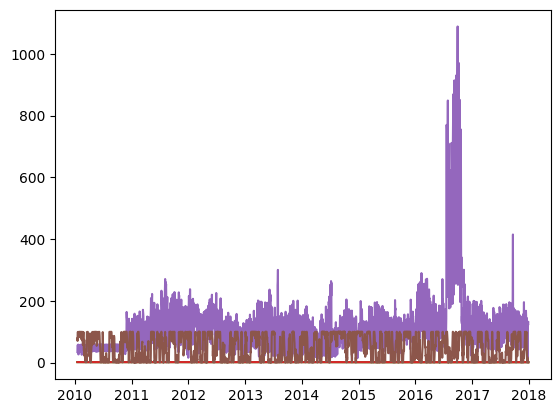

In [600]:
#Lets split the data into train (80%) and Test (20%)
split_index= int(len(daily_close_data)*.80)
train_data=daily_close_data.iloc[:split_index]
test_data=daily_close_data.iloc[split_index:]

print(train_data)
print(test_data)

train_data=train_data.dropna()

plt.plot(train_data)



In [601]:
stdz_train, stdz_test =Standardize_here(train_data, test_data)
stdz_train=stdz_train.dropna()
stdz_test=stdz_test.dropna()

stdz_train

,Open,High,Low,Close,Volume,LWR
DateTimeIndex,,,,,,
2010-01-17,1.601317,1.601778,1.600954,1.601581,-0.912012,0.696618
2010-01-18,1.615264,1.615916,1.614262,1.615419,-0.721751,0.488353
2010-01-19,1.578080,1.578894,1.576773,1.578106,-0.728780,1.215924
2010-01-20,1.427999,1.428952,1.426478,1.427967,-0.720902,1.235072
2010-01-21,1.365545,1.366652,1.363963,1.365606,-0.728932,1.237862
...,...,...,...,...,...,...
2017-12-25,-0.554342,-0.554941,-0.553681,-0.554307,-1.055095,-1.057545
2017-12-26,-0.548755,-0.549345,-0.548156,-0.548778,-0.569707,-1.187589
2017-12-27,-0.531074,-0.531464,-0.530631,-0.531059,-0.113723,-1.296493


In [602]:
stdz_test

,Open,High,Low,Close,Volume,LWR
DateTimeIndex,,,,,,
2018-01-01,-0.423063,-0.423436,-0.422628,-0.423070,-0.583603,-1.300665
2018-01-02,-0.395592,-0.395931,-0.395199,-0.395573,-0.009463,-1.301190
2018-01-03,-0.405014,-0.405383,-0.404670,-0.405055,-0.022998,-1.192882
2018-01-04,-0.391242,-0.391541,-0.390897,-0.391223,0.069107,-1.299236
2018-01-05,-0.385265,-0.385596,-0.384965,-0.385300,0.049250,-1.297835
...,...,...,...,...,...,...
2019-12-26,-1.212214,-1.212821,-1.211604,-1.212216,-0.888475,0.749752
2019-12-27,-1.169173,-1.169543,-1.168757,-1.169134,-0.382792,-0.865505
2019-12-29,-1.139730,-1.140105,-1.139455,-1.139789,-0.968480,-1.291810


[[ 1.60163876  1.60209969  1.60127588  1.60190315 -0.91219493  0.69675821]
 [ 1.6155883   1.61624112  1.61458646  1.61574404 -0.72189641  0.48845136]
 [ 1.57839677  1.5792116   1.57708937  1.57842343 -0.72892633  1.21616871]
 ...
 [-0.53118064 -0.53157129 -0.53073734 -0.5311661  -0.11374631 -1.29675376]
 [-0.48951735 -0.48997591 -0.48901579 -0.48950609 -0.14438051 -1.30026021]
 [-0.45173344 -0.45213035 -0.45127445 -0.4517095  -0.06967796 -1.30082271]]
[[ 1.22550541  1.22496213  1.22613286  1.22551524 -1.20996216 -1.44039232]
 [ 1.30254933  1.30208447  1.30307327  1.30263338 -0.36804109 -1.44094614]
 [ 1.27612472  1.27558257  1.27650807  1.27603985 -0.38788919 -1.3267706 ]
 ...
 [-0.784418   -0.78452384 -0.78462348 -0.78456958 -1.77434702 -1.43105726]
 [-0.73487466 -0.73503592 -0.73468337 -0.73484154 -0.96040141 -1.43576702]
 [-0.71195743 -0.7124024  -0.7114691  -0.71187902 -1.34238167 -1.43931003]]


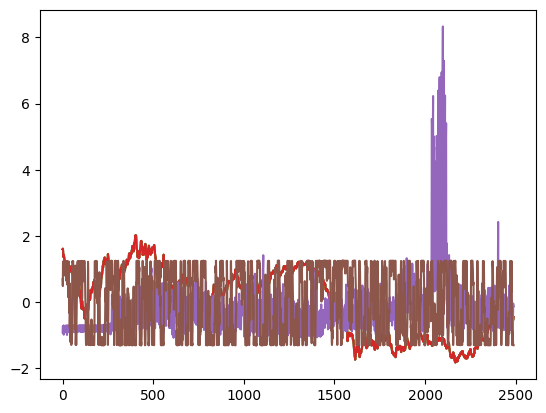

In [603]:
scaler=StandardScaler()
scaler.fit(train_data)

train_tt=scaler.fit_transform(train_data)
test_tt=scaler.fit_transform(test_data)

print(train_tt)
print(test_tt)

plt.plot(train_tt)

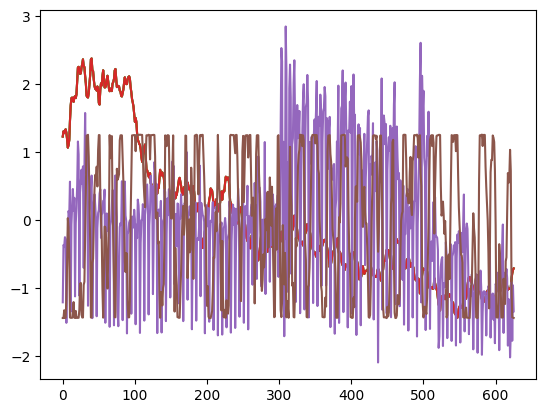

In [604]:
plt.plot(test_tt)

In [605]:

stdz_train['Label']=stdz_train['Close'].shift(-1)
stdz_train
stdz_test['Label']=stdz_test['Close'].shift(-1)
stdz_test
stdz_train

,Open,High,Low,Close,Volume,LWR,Label
DateTimeIndex,,,,,,,
2010-01-17,1.601317,1.601778,1.600954,1.601581,-0.912012,0.696618,1.615419
2010-01-18,1.615264,1.615916,1.614262,1.615419,-0.721751,0.488353,1.578106
2010-01-19,1.578080,1.578894,1.576773,1.578106,-0.728780,1.215924,1.427967
2010-01-20,1.427999,1.428952,1.426478,1.427967,-0.720902,1.235072,1.365606
2010-01-21,1.365545,1.366652,1.363963,1.365606,-0.728932,1.237862,1.404849
...,...,...,...,...,...,...,...
2017-12-25,-0.554342,-0.554941,-0.553681,-0.554307,-1.055095,-1.057545,-0.548778
2017-12-26,-0.548755,-0.549345,-0.548156,-0.548778,-0.569707,-1.187589,-0.531059
2017-12-27,-0.531074,-0.531464,-0.530631,-0.531059,-0.113723,-1.296493,-0.489408


In [606]:
stdz_train.drop(columns=['Open','High','Low','Volume'], inplace= True)
stdz_train

,Close,LWR,Label
DateTimeIndex,,,
2010-01-17,1.601581,0.696618,1.615419
2010-01-18,1.615419,0.488353,1.578106
2010-01-19,1.578106,1.215924,1.427967
2010-01-20,1.427967,1.235072,1.365606
2010-01-21,1.365606,1.237862,1.404849
...,...,...,...
2017-12-25,-0.554307,-1.057545,-0.548778
2017-12-26,-0.548778,-1.187589,-0.531059
2017-12-27,-0.531059,-1.296493,-0.489408


In [607]:
stdz_test.drop(columns=['Open','High','Low','Volume'], inplace= True)
stdz_test

,Close,LWR,Label
DateTimeIndex,,,
2018-01-01,-0.423070,-1.300665,-0.395573
2018-01-02,-0.395573,-1.301190,-0.405055
2018-01-03,-0.405055,-1.192882,-0.391223
2018-01-04,-0.391223,-1.299236,-0.385300
2018-01-05,-0.385300,-1.297835,-0.402551
...,...,...,...
2019-12-26,-1.212216,0.749752,-1.169134
2019-12-27,-1.169134,-0.865505,-1.139789
2019-12-29,-1.139789,-1.291810,-1.122058



def fill_nan_with_avg(series):
    # Find the NaN values
    nan_mask = series.isna()

    # Calculate the average of the previous and next rows for each NaN value
    avg_values = (series.shift(1) + series.shift(-1)) / 2

    # Update NaN values with the calculated average values
    series[nan_mask] = avg_values[nan_mask]

# Apply the fill_nan_with_avg function to the 'Close' column
fill_nan_with_avg(daily_close_data['Close'])

# Print the updated DataFrame
print(daily_close_data)


In [608]:
#X_train=pd.DataFrame()


In [609]:
X_train= stdz_train.copy()
X_test = stdz_test.copy()
X_train.drop(columns='Label', inplace = True)
X_test.drop(columns='Label', inplace=True)
print(X_train)
print(stdz_train)
print(stdz_test)

                  Close       LWR
DateTimeIndex                    
2010-01-17     1.601581  0.696618
2010-01-18     1.615419  0.488353
2010-01-19     1.578106  1.215924
2010-01-20     1.427967  1.235072
2010-01-21     1.365606  1.237862
...                 ...       ...
2017-12-25    -0.554307 -1.057545
2017-12-26    -0.548778 -1.187589
2017-12-27    -0.531059 -1.296493
2017-12-28    -0.489408 -1.299999
2017-12-29    -0.451619 -1.300561

[2489 rows x 2 columns]
                  Close       LWR     Label
DateTimeIndex                              
2010-01-17     1.601581  0.696618  1.615419
2010-01-18     1.615419  0.488353  1.578106
2010-01-19     1.578106  1.215924  1.427967
2010-01-20     1.427967  1.235072  1.365606
2010-01-21     1.365606  1.237862  1.404849
...                 ...       ...       ...
2017-12-25    -0.554307 -1.057545 -0.548778
2017-12-26    -0.548778 -1.187589 -0.531059
2017-12-27    -0.531059 -1.296493 -0.489408
2017-12-28    -0.489408 -1.299999 -0.451619
2017-

In [610]:
X_test=X_test.dropna()
X_train=X_train.dropna()


In [611]:
y_train = stdz_train.copy()
y_test = stdz_test.copy()
y_train.drop(columns=['Close','LWR'], inplace= True)
y_test.drop(columns=['Close','LWR'],inplace=True)
y_train=y_train.dropna()
y_test=y_test.dropna()


    

In [612]:
print(len(X_train),len(y_train))
X_ind= X_train.index
y_ind= y_train.index


missing={}

if len(X_train)!= len(y_train):
    missing = X_ind[~X_ind.isin(y_ind)]
    missing.append(y_ind[~y_ind.isin(X_ind)])
    print(missing)
 

2489 2488
DatetimeIndex(['2017-12-29'], dtype='datetime64[ns]', name='DateTimeIndex', freq=None)


In [613]:

X_train=X_train.drop(missing)
print(len(X_train),len(y_train))


2488 2488


In [614]:
X_test_ind=X_test.index
y_test_ind=y_test.index

if len(X_test)!= len(y_test):
    missing = X_test_ind[~X_test_ind.isin(y_test_ind)]
    missing.append(y_test_ind[~y_test_ind.isin(X_test_ind)])
    print(missing)
X_test=X_test.drop(missing)  

DatetimeIndex(['2019-12-31'], dtype='datetime64[ns]', name='DateTimeIndex', freq=None)


In [615]:
#create numpy arrays from the train, test dataframes
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [616]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2488, 2)
Shape of y_train: (2488, 1)
Shape of X_test: (625, 2)
Shape of y_test: (625, 1)


In [617]:
missing_values = np.isnan(y_train)
print("Number of missing values in y_train:", np.sum(missing_values))

X_train

y_train

Number of missing values in y_train: 0


array([[ 1.61541943],
       [ 1.57810632],
       [ 1.42796707],
       ...,
       [-0.53105939],
       [-0.48940775],
       [-0.45161875]])

In [618]:
#Create a Linear Regression model
model = LinearRegression()

#Train the model on the training data
model.fit(X_train, y_train)
#model.score(X_test, y_test)

LinearRegression()

In [619]:
display(model)


LinearRegression()

In [620]:
print('Training set score: ' + str(round(model.score(X_train,y_train),4)))
print('Test set score: ' + str(round(model.score(X_test,y_test),4)))

Training set score: 0.9979
Test set score: 0.9943


In [621]:
forecast=model.predict(X_test)
forecasty=model.predict(X_train)
print(forecast,forecasty)

[[-0.41562927]
 [-0.38818134]
 [-0.39826636]
 [-0.38385085]
 [-0.37794749]
 [-0.39659198]
 [-0.43449212]
 [-0.48195181]
 [-0.46794314]
 [-0.4384651 ]
 [-0.33200607]
 [-0.25380103]
 [-0.21451247]
 [-0.21174792]
 [-0.2215471 ]
 [-0.23554007]
 [-0.20951661]
 [-0.20461323]
 [-0.2154567 ]
 [-0.19459181]
 [-0.12007648]
 [-0.05435448]
 [-0.05127725]
 [-0.06427247]
 [-0.09092438]
 [-0.08858203]
 [-0.0540321 ]
 [-0.03581802]
 [-0.01214995]
 [-0.05091147]
 [-0.05478765]
 [-0.10713982]
 [-0.14797959]
 [-0.21693717]
 [-0.22395109]
 [-0.22609276]
 [-0.20079693]
 [-0.14866863]
 [-0.099884  ]
 [-0.01159674]
 [-0.00752657]
 [-0.07276394]
 [-0.07764417]
 [-0.12516274]
 [-0.16133962]
 [-0.17810789]
 [-0.17421748]
 [-0.18793977]
 [-0.16430095]
 [-0.18696202]
 [-0.25458597]
 [-0.26324253]
 [-0.18079755]
 [-0.14537757]
 [-0.15560007]
 [-0.10297632]
 [-0.06925995]
 [-0.11168108]
 [-0.16617004]
 [-0.16552251]
 [-0.15457186]
 [-0.12001328]
 [-0.1002329 ]
 [-0.13247083]
 [-0.17172091]
 [-0.19331463]
 [-0.17759

In [622]:
from sklearn.metrics import r2_score
R2=r2_score(y_test,forecast)
formatted_R2="{:.4f}".format(R2)

formatted_R2

'0.9943'

In [623]:
#De standardize the forecast 

De_std_forecast= De_Standardize_here(train_data,forecast)

De_std_forecast

ValueError: Length of values (625) does not match length of index (6)